## Batch TFF System - 200 Da Membrane with 0.5um Pre-filtered Feed

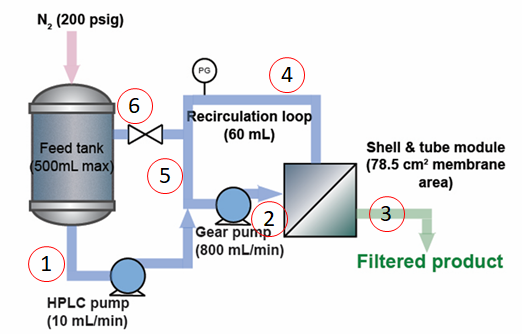

In [ ]:
#Import Packages and Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
idx = pd.IndexSlice
import scipy.optimize as optimize
from scipy.optimize import least_squares

#Adjust window size for Jupyter notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Import Scripts
import TFF_Functions as tff
import Module as mod

In [ ]:
def optimizeBatchTFF(alpha):
    #Inputs:
    #For all inputs/outputs, indexes 0, 1, 2 = Hydroxy, Aromatic, Unaccounted, respectively
    diff = np.array([9.90E-10,8.4E-10,4.3E-10]) # Diffusivity coefficient, m^2/s
    vantHoff = np.array([1, 0.63, 0.03]) #Van't Hoff coefficient, dimensionless
    osmo_factor = 32413810 #Osmotic factor, Pa/massfrac
    MRpercent_desired = .7601 #Mass reduction % to run to
    mass_Mcup_init = .20958 #Total inital mass in feed chamber, kg
    recyc_holdup = (60)/1000 #Volume in recycle loop, kg (mL)
    flux_init = (36.75)/3600 #Initial flux, kg/m^2/s (LMH) 
    flux_asy = (0)/3600 #Asymptotic flux, kg/m^2/s (LMH) 
    P_in = 208 #Feed side pressure, psi
    numModuleCells = 10 #Number of cells in module

    module = mod.setMod(P_in, numModuleCells, flux_init, osmo_factor)
    module['alpha'] = alpha
    
    #Initial Feed specifications (Stream 1)
    #Define species input data as dataframe
    num_components = 3
    comp_inputs = pd.DataFrame(data=np.zeros((num_components,5)),columns=('MFR','c','x','diff','vantHoff'))
    #Set species data
    pumpCalParams=[0.00692857,-0.00810119] #Pump calibration parameters
    comp_inputs['MFR'] = tff.mfr(3,*pumpCalParams) #Input Mass Flow Rate, kg/s (kg/min)
    comp_inputs['c'] = np.array([6.2,1.2,22.3]) #Initial concentration of solute, g/L
    comp_inputs['x'] = (comp_inputs['c']/(comp_inputs['c'].sum()+1000)).values #Initial mass fraction
    comp_inputs['diff']= diff
    comp_inputs['vantHoff']= vantHoff
    
    #Initial Mixing Cup Specifications
    mass_Mcup_compInit = comp_inputs['x']*mass_Mcup_init #Initial mass of each component, kg
    mass_Mcup = mass_Mcup_init-recyc_holdup #Mixing Cup Volume, kg (this is adjusted for filling the 60mL recirculation loop)
    x_Mcup = comp_inputs['c']/(comp_inputs['c'].sum()+1000) #Mixing cup mass fractions
    
    #Module specs
    fluxDecParams = np.array([ flux_init, flux_asy, 0.26429949]) #<-- Final value is m from flux decline fit
    t = MRpercent_desired*mass_Mcup_init/(module['F_p'])
    numTimesteps = int(t*6)

    #Initial Perm Cup Specs
    mass_Pcup = 0
    x_Pcup = [0,0,0]

    #Establish matrix to collect PFD mass balance data
    #Indexes 0,1,2 are mass fractions, 3 is MFR
    streamData = pd.DataFrame(data=np.zeros((numTimesteps+1,32)),columns=[[1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8],
                                                                   [0,1,2,3,0,1,2,3,0,1,2,3,\
                                                                    0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]])
    streamData.sort_index(inplace=True)

    #Establish dictionaries to collect module outputs dicts and cellData dataframes at each timepoint
    modOutputs = dict()
    cellData_collect = dict()

    #Set mass flowrates for streams which are constant
    streamData.loc[idx[:],idx[1,3]] = (5.5)/1000/60 #HPLC pump flowrate, kg/s (mL/min)
    streamData.loc[idx[:],idx[2,3]] = comp_inputs['MFR'][0] #Gear pump flowrate, kg/s (mL/min)
    streamData.loc[idx[:],idx[5,3]] = streamData.loc[idx[:],idx[2,3]] - streamData.loc[idx[:],idx[1,3]]

    #Set initial mass fractions
    streamData.loc[idx[0],idx[7,0:2]] = comp_inputs['x'].values
    streamData.loc[idx[0],idx[7,3]] = mass_Mcup_init

    #Initial valuess for flux decline fit
    density=1000+comp_inputs['c'].sum()
    totVolFed = 0

    #This loop will solve for the batch system at each timepoint between 0 and numTimesteps
    #It collects the system mass balance data for each stream in streamData and it collects the module outputs

    t=1
    while module['sysMRR'] < MRpercent_desired:
        streamData.loc[idx[t],idx[1,0:2]] = streamData.loc[idx[t-1],idx[7,0:2]].values
        streamData.loc[idx[t],idx[7,3]] = streamData.loc[idx[t-1],idx[7,3]] - streamData.loc[idx[t],idx[1,3]]
        streamData.loc[idx[t],idx[2,0:2]] = (streamData.loc[idx[t],idx[1,0:2]].values*streamData.loc[idx[t],idx[1,3]] + streamData.loc[idx[t-1],idx[5,0:2]].values*streamData.loc[idx[t-1],idx[5,3]])/streamData.loc[idx[t],idx[2,3]]
        comp_inputs['x'] = streamData.loc[idx[t],idx[2,0:2]].values

        #Update permeate flowrate due to flux decline
        totVolFed = totVolFed + comp_inputs['MFR'][0]/density*1000 #Volume of feed which has run through module
        flux = tff.fluxFit(totVolFed, *fluxDecParams) 
        module['F_p'] = flux*module['SA']

        cellData = tff.TFF(comp_inputs,module)
        output = tff.moduleOutputsCalc(comp_inputs,module,cellData)
        density = output['density_r']

        #Solve mass balance for all streams
        streamData.loc[idx[t],idx[3,3]] = output['F_perm']
        streamData.loc[idx[t],idx[3,0:2]] = output['x_perm']
        streamData.loc[idx[t],idx[4,3]] = output['F_ret']
        streamData.loc[idx[t],idx[4,0:2]] = output['x_ret']
        streamData.loc[idx[t],idx[5,0:2]] = output['x_ret']
        streamData.loc[idx[t],idx[6,3]] = streamData.loc[idx[t],idx[4,3]]-streamData.loc[idx[t],idx[5,3]]
        streamData.loc[idx[t],idx[6,0:2]] = output['x_ret']

        #Calculate permeate total mass, new mass fractions
        mass_comp_Pcup = (np.array(streamData.loc[idx[t-1],idx[8,0:2]])*streamData.loc[idx[t-1],idx[8,3]] + streamData.loc[idx[t],idx[3,0:2]]*streamData.loc[idx[t],idx[3,3]]).values #Total mass of each component in permeate cup
        streamData.loc[idx[t],idx[8,3]] = streamData.loc[idx[t-1],idx[8,3]] + streamData.loc[idx[t],idx[3,3]] #New mass of permeate cup with addition from permeate stream
        streamData.loc[idx[t],idx[8,0:2]] = mass_comp_Pcup/streamData.loc[idx[t],idx[8,3]] #New mass fraction of each component based on new total mass   

        #Solve mass balance for mixing cup
        mass_comp_Mcup = (np.array(streamData.loc[idx[t-1],idx[7,0:2]])*streamData.loc[idx[t],idx[7,3]] + streamData.loc[idx[t],idx[6,0:2]]*streamData.loc[idx[t],idx[6,3]]).values #Mass of components in  mixing cup
        streamData.loc[idx[t],idx[7,3]] = streamData.loc[idx[t],idx[7,3]] + streamData.loc[idx[t],idx[6,3]] #Total mass in mixing cup
        streamData.loc[idx[t],idx[7,0:2]] = mass_comp_Mcup/streamData.loc[idx[t],idx[7,3]] #New mass fractions

        #Calculate overall Mass recovery ratio (MRR)
        module['sysMRR'] = streamData.loc[idx[t],idx[8,3]]/mass_Mcup_init
        output['sysMRR'] = module['sysMRR']
        modOutputs[t]= output
        cellData_collect[t] = cellData
        t=t+1

    #Build dataframe with outputs for each datapoint
    keys = output.keys()
    outputData = pd.DataFrame(data=np.zeros((t-1,len(output))),columns=keys)
    for x in range(1,t):
        outputData.loc[idx[x-1],idx[:]] = modOutputs[x]

    #Convert mass fractions to concentrations for PFD
    streamData2 = streamData.copy()
    y=8
    for x in range(0,t):
            streamData2.loc[idx[x],idx[y,:2]] = tff.solveConc(streamData.loc[idx[x],idx[y,:2]].values)

    #Compare simulation results to experimental for objective function
    import math
    od=outputData.copy()
    od.drop(0,inplace=True)
    results = pd.DataFrame(data=np.zeros((4,10)),columns=[[0,0,0,1,1,1,2,2,2,3],['x_pcup','c_pcup','c_exp','x_pcup','c_pcup','c_exp','x_pcup','c_pcup','c_exp','ind']],index=[0.25,0.5,0.7,0.76])
    
    #Experimental concentration data
    results[0,'c_exp'] = [4.710,5.365,5.890,6.047]
    results[1,'c_exp'] = [0.294,.560,.773,.837]
    results[2,'c_exp'] = [2.305,3.228,3.967,4.189]

    indCount = 0
    abs_tol=0.0001
    for x in range(1, len(od)):
        if math.isclose(od.loc[idx[x],idx['sysMRR']],results.index[indCount],abs_tol=abs_tol)==True:
            results.loc[idx[results.index[indCount]],idx[3,'ind']] = x
            indCount += 1
            if indCount == 4:
                break

    #Insert permeate cup concentrations from streamdata2 dataframe into results dataframe
    for comp in range(0,3):
        for mrr in range(0,4):
            results.loc[idx[results.index[mrr]],idx[comp,'c_pcup']] = streamData2.loc[idx[results.loc[idx[results.index[mrr]],idx[3,'ind']]],idx[8,comp]]
            results.loc[idx[results.index[mrr]],idx[comp,'x_pcup']] = streamData.loc[idx[results.loc[idx[results.index[mrr]],idx[3,'ind']]],idx[8,comp]]
    print(module['alpha'])
    print(results)
    
    #Plot final concentrations
    s=8
    plt.plot(outputData.loc[idx[1:],idx['sysMRR']]*100,streamData2.loc[idx[1:len(outputData)-1],idx[s,0]],'r*',label='aliphatic')
    plt.plot(outputData.loc[idx[1:],idx['sysMRR']]*100,streamData2.loc[idx[1:len(outputData)-1],idx[s,1]],'g*',label='aromatic')
    plt.plot(outputData.loc[idx[1:],idx['sysMRR']]*100,streamData2.loc[idx[1:len(outputData)-1],idx[s,2]],'b*',label='unknown')
    plt.legend()
    plt.xlabel('Vol. Reduction %')
    plt.ylabel('Concentration, g/L')
    plt.title('S8: Permeate Mixing Cup')  
    
    #Calculate differences between simulation and experimental permeate cup values
    diff = results.loc[idx[:],idx[:,'c_pcup']] - results.loc[idx[:],idx[:,'c_exp']].values
    obj = [diff[0].sum()[0], diff[1].sum()[0], diff[2].sum()[0]]
    print(obj)
    print()
    return obj

In [ ]:
guess = np.array([1.62819898e-07,  3.62021670e-06,  2.24117574e-05]) #Initial guess for membrane selectivity
res = least_squares(optimizeBatchTFF, guess)
print(res)

In [ ]:
res